# Using the median of $n$ buses in the last Day, 30 minutes

8700-10-1 MAPE(all) = 10.82%
8700-10-1 MAPE(Thresh > 50) = 9.48%
7545-10-1 MAPE(all) = 15.92%
7545-10-1 MAPE(Thresh > 50) = 13.71%
7545-10-0 MAPE(all) = 14.16%
7545-10-0 MAPE(Thresh > 50) = 12.47%
6450-10-1 MAPE(all) = 14.81%
6450-10-1 MAPE(Thresh > 50) = 12.21%
6450-10-0 MAPE(all) = 16.85%
6450-10-0 MAPE(Thresh > 50) = 13.75%
3301-10-1 MAPE(all) = 15.22%
3301-10-1 MAPE(Thresh > 50) = 12.45%
2290-10-1 MAPE(all) = 14.35%
2290-10-1 MAPE(Thresh > 50) = 12.94%
2290-10-0 MAPE(all) = 21.31%
2290-10-0 MAPE(Thresh > 50) = 16.17%
477P-10-0 MAPE(all) = 25.47%
477P-10-0 MAPE(Thresh > 50) = 18.44%


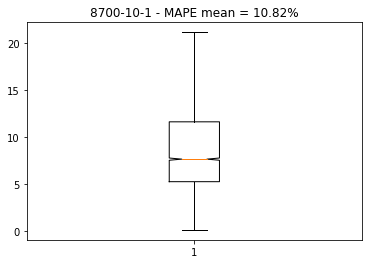

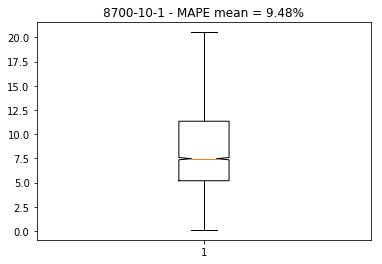

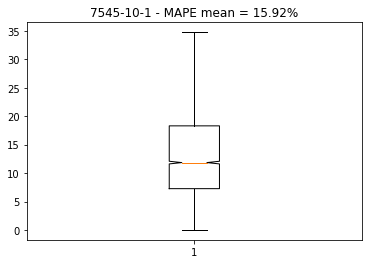

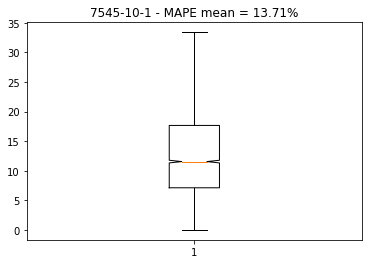

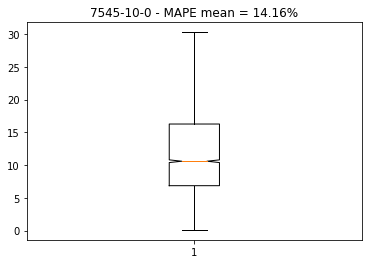

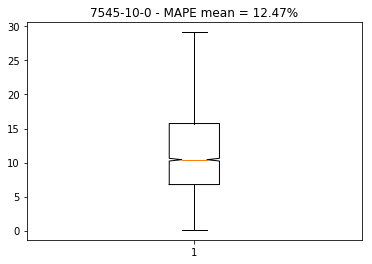

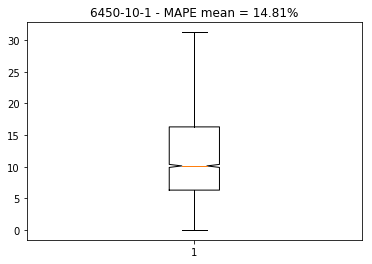

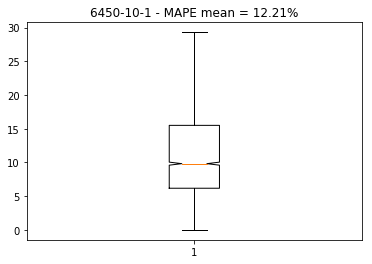

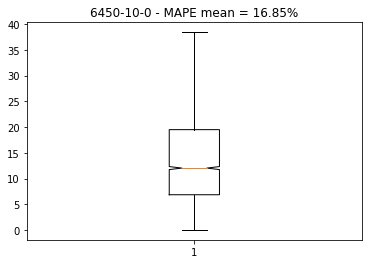

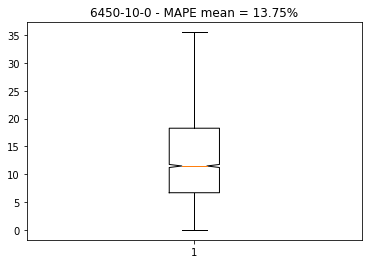

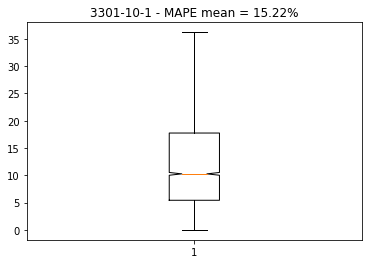

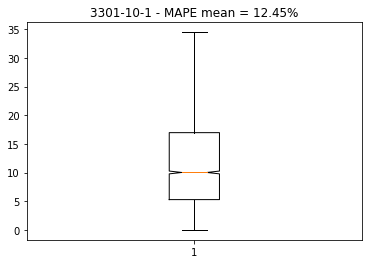

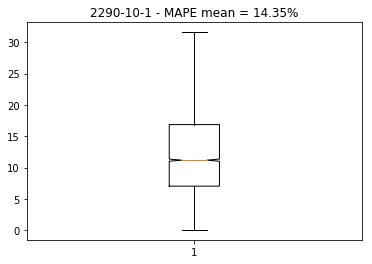

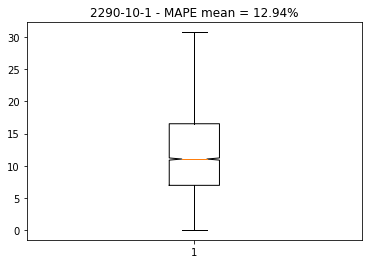

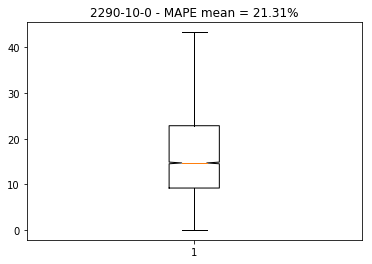

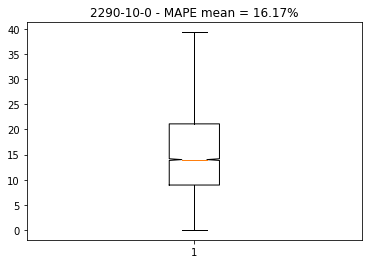

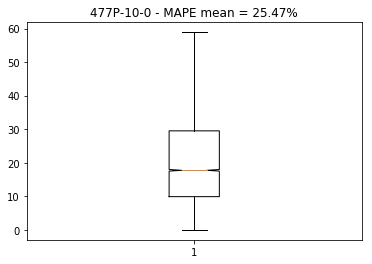

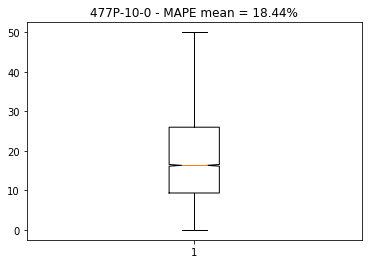

In [31]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import heapq 
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import dateutil
import datetime 
from time import time
import re
from scipy import interpolate
import timeit
from dateutil.rrule import DAILY, rrule, MO, TU, WE, TH, FR
import seaborn as sns

from sklearn.metrics import mean_absolute_error
import math

import sys
sys.path.append("../")


from historical.readData.old.estimateData3 import read

from historical.readData.old.estimateData3 import read
from historical.readData.old.estimateData3 import search_travels
from historical.readData.old.estimateData3 import estimate
from historical.readData.old.estimateData3 import stops_distance

from historical.readData.old.travels3 import haversine2

def calcula_dist_shape(selec_linhas):
    distance_all_shapes = {}
    # print 'Calculando distancias dos shapes'
    '''calcula todas as distancias dos shapes'''
    
    pth_files_GTFS = "../historical/readData/dados/gtfs/"        
        
    trips = pd.read_csv(pth_files_GTFS + 'trips.txt', sep=',')
    shapes = pd.read_csv(pth_files_GTFS + 'shapes.txt', sep=',')
    
    for l, trip_id in enumerate(selec_linhas):

        trip = trips[trips.trip_id == trip_id]
        trip_shape = shapes[shapes['shape_id'].isin(trip['shape_id'])]
        shapelat = trip_shape.shape_pt_lat.tolist()
        shapelon = trip_shape.shape_pt_lon.tolist()

        # distancias dos shapes
        lon1 = shapelon[0]
        lat1 = shapelat[0]
        totalcal = [0.]
        dist = [0.]
        for lat2, lon2 in zip(shapelat[1:], shapelon[1:]):
            d = haversine2(lat1, lon1, lat2, lon2)
            d = d * 1000
            dist.append(d)
            totalcal.append(totalcal[-1] + d)
            lat1 = lat2
            lon1 = lon2
        distance_all_shapes[trip_id] = [shapelat, shapelon, totalcal]
    return distance_all_shapes

def stops_distance(linha):

    distances = calcula_dist_shape([linha])
    totalcal = distances[linha][2]
    
    pth_files_GTFS = "../historical/readData/dados/gtfs/"
    

    trips = pd.read_csv(pth_files_GTFS + 'trips.txt', sep=',')
    shapes = pd.read_csv(pth_files_GTFS + 'shapes.txt', sep=',')
    stops = pd.read_csv(pth_files_GTFS + 'stops.txt', sep=',')
    stopid = pd.read_csv(pth_files_GTFS + 'stop_times.txt', sep=',')   

    ida = trips[trips.trip_id == linha]
    shapeida = shapes[shapes['shape_id'].isin(ida['shape_id'])]
    idalat = shapeida.shape_pt_lat.tolist()
    idalon = shapeida.shape_pt_lon.tolist()
    total = shapeida.shape_dist_traveled.tolist()

    temp1 = stopid[stopid.trip_id == linha]
    stopsida = stops[stops['stop_id'].isin(temp1['stop_id'])]
    stopsida = stopsida.set_index('stop_id')
    stopsida = stopsida.reindex(index=temp1['stop_id'])

    stopslat = stopsida.stop_lat.tolist()
    stopslon = stopsida.stop_lon.tolist()

    dpontos = [None] * len(stopslat)
    index = 0
    lat = idalat
    lon = idalon
    total = 0
    p = ['depois'] * len(stopslat)
    for latb, lonb, i in zip(stopslat, stopslon, range(len(stopslat))):
        lat = lat[index:]
        lon = lon[index:]
        nn = haversine2(latb, lonb, np.array(lat), np.array(lon)) * 1000
        index = nn.argmin()
        total = total + index
        if index == 0:
            dpontos[i] = nn[index]
#            descontardist = nn[index]
        else:
            if totalcal[total] >= totalcal[total - 1] + nn[index - 1]:
                p[i] = 'antes'
            dpontos[i] = totalcal[total - 1] + nn[index - 1]

    mid_points = []
#    mid_points.append(200)
    p1 = dpontos[0]
    for p2 in dpontos[1:]:
        mid_points.append(p1 + (p2-p1)/2)
        p1 = p2
    dpontos = [i/1000. for i in dpontos]
    mid_points = [i/1000. for i in mid_points]
    # dpontos = [val-descontardist for val in dpontos]
    # stopsida.reset_index(drop=True, inplace=True)
    # stopsida['distancia'] = dpontos
    # stopsida.sort_values('distancia',axis=0,inplace=True)
    # stopsida.reset_index(drop=True, inplace=True)

    # gmap = gmplot.GoogleMapPlotter(idalat[0], idalon[0], 19)
    # gmap.marker(idalat[0],idalon[0], title='Test text')
    # gmap.plot(idalat, idalon, 'blue')
    # gmap.scatter(idalat, idalon, c='blue', size=10, marker=True, titles=totalcal)
    # gmap.scatter(stopsida['stop_lat'].tolist(), stopsida['stop_lon'].tolist(), c='red', size=10, marker=True,
    #             titles=["Ponto " + str(i + 1) + ": dist: " + str(stopsida['distancia'][i]) + ' ' + p[i] for i in
    #                     range(len(dpontos))])

    # gmap.draw('pontos.html')

    return dpontos, mid_points

def read(filedata,filerep):
    df0 = pd.read_pickle(filedata, compression=None)
    with open(filerep, 'rb') as handle:
        reps = pickle.load(handle, encoding='latin1')
    return df0, reps

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + datetime.timedelta(n)
        
def daterangeWD(start_date, end_date):
  return rrule(DAILY, dtstart=start_date, until=end_date, byweekday=(MO,TU,WE,TH,FR))

def hr_func(ts):
    return ts.hour

def minute_func(ts):
    return ts.minute

def second_func(ts):
    return ts.second

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')


# if __name__ == '__main__':

selected_line = ['8700-10-1']

selected_line = ['8700-10-1',                
                '7545-10-1',
                '7545-10-0',
                '6450-10-1',
                '6450-10-0',
                '3301-10-1',
#                 '3301-10-0',
                '2290-10-1',
                '2290-10-0',
#                 '574J-10-1',
#                 '574J-10-0',
#                 '477P-10-1',
                '477P-10-0',
#                 '351F-10-1',
#                 '351F-10-0'
                ]

pth_files_GTFS = "../historical/readData/dados/gtfs/"

trips = pd.read_csv(pth_files_GTFS + 'trips.txt', sep=',')
shapes = pd.read_csv(pth_files_GTFS + 'shapes.txt', sep=',')
stops = pd.read_csv(pth_files_GTFS + 'stops.txt', sep=',')
stopid = pd.read_csv(pth_files_GTFS + 'stop_times.txt', sep=',')   

periods = ['morning', 'm_peak', 'i_peak', 'a_peak', 'night']

for line in selected_line:
#     line = selected_line[0]
    p, mp = stops_distance(line)
    pth_files_lines = "../historical/readData/"

    ### Operação demorada
    df, reps = read(pth_files_lines + "trips_" + line + ".dsk", pth_files_lines + "interps_" + line + ".rep")

    df['day'] = pd.to_datetime(df['day'], format = '%Y-%m-%d')
    df['start'] = pd.to_datetime(df['start'], format = '%H:%M:%S')

    end_date = datetime.date(2017, 9, 1)        

    df = df.loc[((df['day'] >= end_date) & (df['holiday'] != 1)) & ((df['weekday'] != 6) & (df['weekday'] != 5) & (df['weekday'] != 4) & (df['weekday'] != 0))]

    df['exact_time'] = np.array(df['day'], dtype='datetime64[ns]') + \
                        pd.to_timedelta(pd.to_timedelta(pd.DatetimeIndex(df['start']).hour*60 + \
                        pd.DatetimeIndex(df['start']).minute + \
                        pd.DatetimeIndex(df['start']).second/60 + \
                        df['time'], unit='m'))

    df.index = df['exact_time']
    df.iloc[df.index.indexer_between_time('08:00', '20:00')]

    df['day_hour'] = df['exact_time'].apply(hr_func)

    df['link'] = 0
    for i in range(0, len(mp)):
        if (i == 0):
              df.loc[df.loc[(df['distance'] > 0) & (df['distance'] < mp[i+1]),]['link'].index,'link'] = i    
        if (i == len(mp) -1):
            df.loc[df.loc[(df['distance'] > mp[i]) & (df['distance'] < max(p)),]['link'].index,'link'] = i    
        if (i != 0) & (i != len(mp)-1):
            df.loc[df.loc[(df['distance'] >= mp[i]) & (df['distance'] < mp[i+1]),]['link'].index,'link'] = i    

    df = df.drop_duplicates(subset=['day', 'numtravel', 'link', 'day_hour'])   

    link_df = []
    travels = sorted(list(set(df.numtravel.unique())))
    for tr in travels:
        tck = reps[tr][0]
        tck_mods = [(tck[0],tck[1]-m,tck[2]) for m in mp]       
        tempo = [a[0] if a.size>0 else np.nan for a in [interpolate.sproot(tck_mod) for tck_mod in tck_mods]]
        row = [tuple([tempo[i+1]-pos for i, pos in enumerate(tempo[:-1])])]    
        link_df.append(row)

    travel_times = pd.DataFrame(np.reshape(link_df, (np.shape(link_df)[0], np.shape(link_df)[2])))
    travel_times.index = travels
    
    MAPE_array = []

    selected_day = df.day.dt.strftime('%Y-%m-%d').unique()
    for day_iteration in range(0, len(selected_day) -1):
        for link in range(1, len(mp)-2):
            df_temp = df.loc[(df['day'] == selected_day[day_iteration]) & (df['link'] == link)]
            df_test = df.loc[(df['day'] == selected_day[day_iteration+1]) & (df['link'] == link)]

            for hour_day in range(640, 1320, 30):   
                int_part, float_part = divmod((hour_day/60), 1)

                if float_part != 0:
                    hour_begin = str(int(int_part)) + ':' + '30'
                    hour_end = str(int(int_part + 1 )) + ':' + '00'                
                else:
                    hour_begin = str(int(int_part)) + ':' + '00'
                    hour_end = str(int(int_part)) + ':' + '30'


                df_temp_time = df_temp.iloc[df_temp.index.indexer_between_time( hour_begin, hour_end)]
                df_temp_test = df_test.iloc[df_test.index.indexer_between_time(hour_begin, hour_end)]

                median_test = np.median(travel_times.loc[np.unique(np.array(df_temp_time['numtravel']))][link])
                time_tests = travel_times.loc[np.unique(np.array(df_temp_test['numtravel']))][link]
                
                if (len(time_tests) > 0) & (math.isnan(median_test) == False) & (np.isnan(time_tests).any() == False):
                    MAPE_array.append(mean_absolute_percentage_error([median_test]*len(time_tests), time_tests))


    
    MAPE_array = np.array(MAPE_array)
    print(line + ' MAPE(all) = ' + str(format(np.mean(MAPE_array), '.2f')) + '%')

    median_fig, ax = plt.subplots()
    ax.set_title(line + ' - MAPE mean = ' + str(format(np.mean(MAPE_array), '.2f')) + '%')
    ax.boxplot(MAPE_array, notch=True, showfliers=False)
    median_fig.savefig(line + '_median_last_day_all.png' )


    MAPE_array = MAPE_array[MAPE_array < 50]    
    print(line + ' MAPE(Thresh > 50) = ' + str(format(np.mean(MAPE_array), '.2f')) + '%')

    median_fig, ax = plt.subplots()
    ax.set_title(line + ' - MAPE mean = ' + str(format(np.mean(MAPE_array), '.2f')) + '%')
    ax.boxplot(MAPE_array, notch=True, showfliers=False)
    median_fig.savefig(line + '_median_last_day_MAPE-threshold.png' )


# Using the Median of $𝑛$ buses in the last Day, 60 minutes

8700-10-1 MAPE(all) = 10.32%
8700-10-1 MAPE(Thresh>5) = 9.14%
7545-10-1 MAPE(all) = 14.92%
7545-10-1 MAPE(Thresh>5) = 12.89%
7545-10-0 MAPE(all) = 13.46%
7545-10-0 MAPE(Thresh>5) = 12.21%
6450-10-1 MAPE(all) = 14.80%
6450-10-1 MAPE(Thresh>5) = 12.21%
6450-10-0 MAPE(all) = 16.20%
6450-10-0 MAPE(Thresh>5) = 14.22%
3301-10-1 MAPE(all) = 14.79%
3301-10-1 MAPE(Thresh>5) = 12.60%
2290-10-1 MAPE(all) = 13.37%
2290-10-1 MAPE(Thresh>5) = 12.17%
2290-10-0 MAPE(all) = 21.19%
2290-10-0 MAPE(Thresh>5) = 16.02%
477P-10-0 MAPE(all) = 22.58%
477P-10-0 MAPE(Thresh>5) = 18.50%


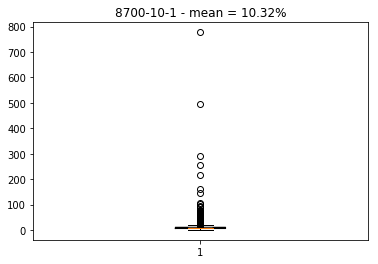

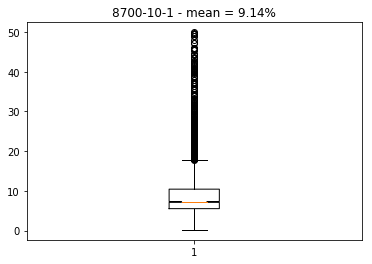

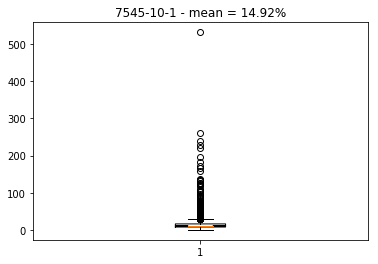

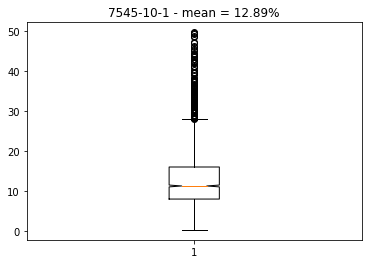

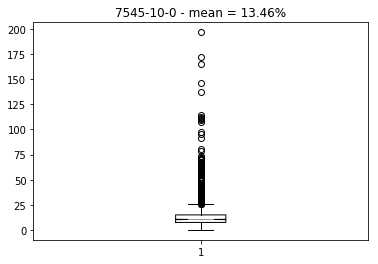

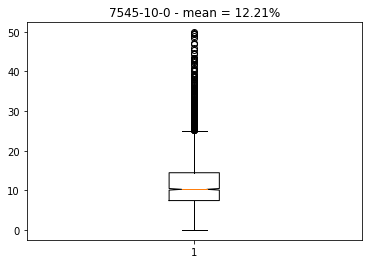

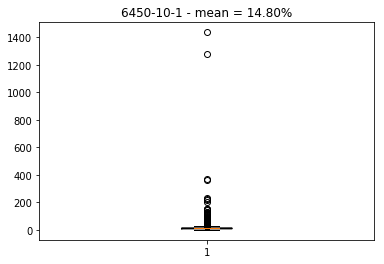

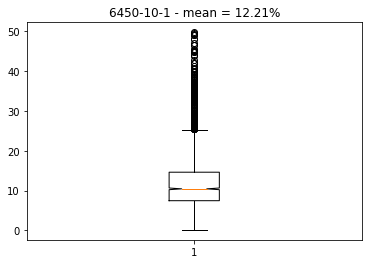

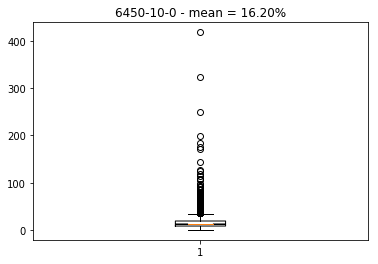

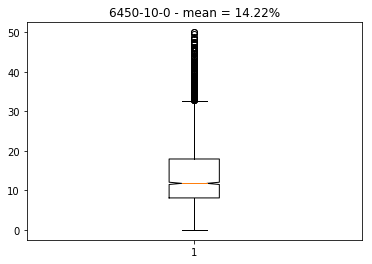

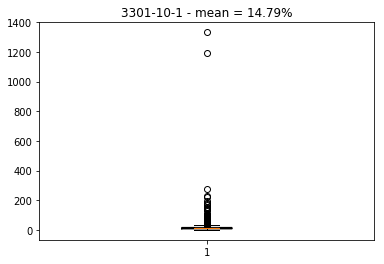

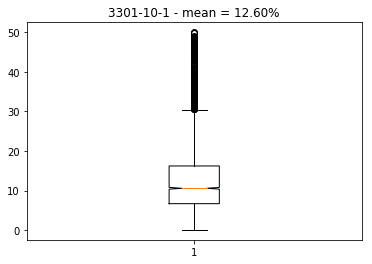

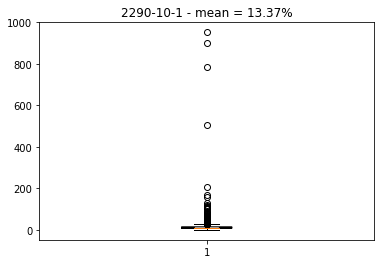

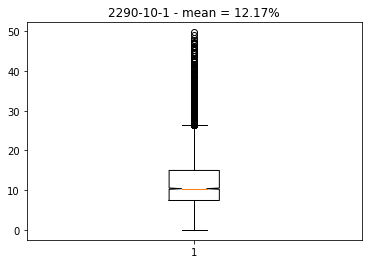

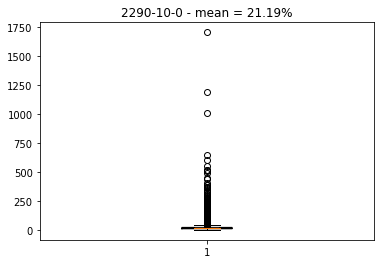

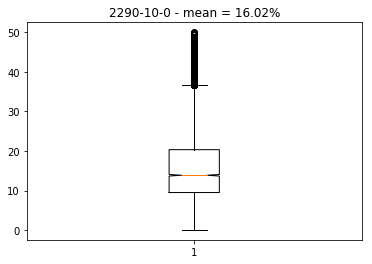

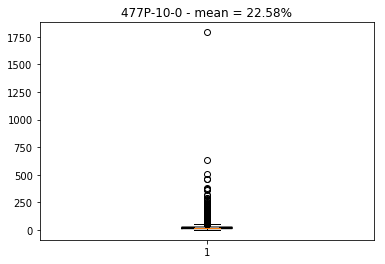

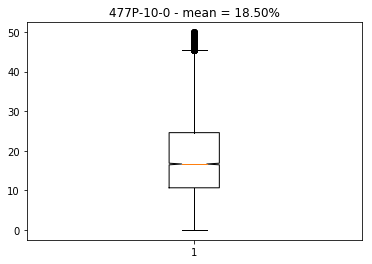

In [32]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import heapq 
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import dateutil
import datetime 
from time import time
import re
from scipy import interpolate
import timeit
from dateutil.rrule import DAILY, rrule, MO, TU, WE, TH, FR
import seaborn as sns

from sklearn.metrics import mean_absolute_error
import math

import sys
sys.path.append("../")


from historical.readData.old.estimateData3 import read

from historical.readData.old.estimateData3 import read
from historical.readData.old.estimateData3 import search_travels
from historical.readData.old.estimateData3 import estimate
from historical.readData.old.estimateData3 import stops_distance

from historical.readData.old.travels3 import haversine2

def calcula_dist_shape(selec_linhas):
    distance_all_shapes = {}
    # print 'Calculando distancias dos shapes'
    '''calcula todas as distancias dos shapes'''
    
    pth_files_GTFS = "../historical/readData/dados/gtfs/"        
        
    trips = pd.read_csv(pth_files_GTFS + 'trips.txt', sep=',')
    shapes = pd.read_csv(pth_files_GTFS + 'shapes.txt', sep=',')
    
    for l, trip_id in enumerate(selec_linhas):

        trip = trips[trips.trip_id == trip_id]
        trip_shape = shapes[shapes['shape_id'].isin(trip['shape_id'])]
        shapelat = trip_shape.shape_pt_lat.tolist()
        shapelon = trip_shape.shape_pt_lon.tolist()

        # distancias dos shapes
        lon1 = shapelon[0]
        lat1 = shapelat[0]
        totalcal = [0.]
        dist = [0.]
        for lat2, lon2 in zip(shapelat[1:], shapelon[1:]):
            d = haversine2(lat1, lon1, lat2, lon2)
            d = d * 1000
            dist.append(d)
            totalcal.append(totalcal[-1] + d)
            lat1 = lat2
            lon1 = lon2
        distance_all_shapes[trip_id] = [shapelat, shapelon, totalcal]
    return distance_all_shapes

def stops_distance(linha):

    distances = calcula_dist_shape([linha])
    totalcal = distances[linha][2]
    
    pth_files_GTFS = "../historical/readData/dados/gtfs/"
    

    trips = pd.read_csv(pth_files_GTFS + 'trips.txt', sep=',')
    shapes = pd.read_csv(pth_files_GTFS + 'shapes.txt', sep=',')
    stops = pd.read_csv(pth_files_GTFS + 'stops.txt', sep=',')
    stopid = pd.read_csv(pth_files_GTFS + 'stop_times.txt', sep=',')   

    ida = trips[trips.trip_id == linha]
    shapeida = shapes[shapes['shape_id'].isin(ida['shape_id'])]
    idalat = shapeida.shape_pt_lat.tolist()
    idalon = shapeida.shape_pt_lon.tolist()
    total = shapeida.shape_dist_traveled.tolist()

    temp1 = stopid[stopid.trip_id == linha]
    stopsida = stops[stops['stop_id'].isin(temp1['stop_id'])]
    stopsida = stopsida.set_index('stop_id')
    stopsida = stopsida.reindex(index=temp1['stop_id'])

    stopslat = stopsida.stop_lat.tolist()
    stopslon = stopsida.stop_lon.tolist()

    dpontos = [None] * len(stopslat)
    index = 0
    lat = idalat
    lon = idalon
    total = 0
    p = ['depois'] * len(stopslat)
    for latb, lonb, i in zip(stopslat, stopslon, range(len(stopslat))):
        lat = lat[index:]
        lon = lon[index:]
        nn = haversine2(latb, lonb, np.array(lat), np.array(lon)) * 1000
        index = nn.argmin()
        total = total + index
        if index == 0:
            dpontos[i] = nn[index]
#            descontardist = nn[index]
        else:
            if totalcal[total] >= totalcal[total - 1] + nn[index - 1]:
                p[i] = 'antes'
            dpontos[i] = totalcal[total - 1] + nn[index - 1]

    mid_points = []
#    mid_points.append(200)
    p1 = dpontos[0]
    for p2 in dpontos[1:]:
        mid_points.append(p1 + (p2-p1)/2)
        p1 = p2
    dpontos = [i/1000. for i in dpontos]
    mid_points = [i/1000. for i in mid_points]


    return dpontos, mid_points

def read(filedata,filerep):
    df0 = pd.read_pickle(filedata, compression=None)
    with open(filerep, 'rb') as handle:
        reps = pickle.load(handle, encoding='latin1')
    return df0, reps

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + datetime.timedelta(n)
        
def daterangeWD(start_date, end_date):
  return rrule(DAILY, dtstart=start_date, until=end_date, byweekday=(MO,TU,WE,TH,FR))

def hr_func(ts):
    return ts.hour

def minute_func(ts):
    return ts.minute

def second_func(ts):
    return ts.second


# if __name__ == '__main__':

selected_line = ['8700-10-1']

selected_line = ['8700-10-1',                
                '7545-10-1',
                '7545-10-0',
                '6450-10-1',
                '6450-10-0',
                '3301-10-1',
#                 '3301-10-0',
                '2290-10-1',
                '2290-10-0',
#                 '574J-10-1',
#                 '574J-10-0',
#                 '477P-10-1',
                '477P-10-0',
#                 '351F-10-1',
#                 '351F-10-0'
                ]

pth_files_GTFS = "../historical/readData/dados/gtfs/"

trips = pd.read_csv(pth_files_GTFS + 'trips.txt', sep=',')
shapes = pd.read_csv(pth_files_GTFS + 'shapes.txt', sep=',')
stops = pd.read_csv(pth_files_GTFS + 'stops.txt', sep=',')
stopid = pd.read_csv(pth_files_GTFS + 'stop_times.txt', sep=',')   

periods = ['morning', 'm_peak', 'i_peak', 'a_peak', 'night']

for line in selected_line:
#     line = selected_line[0]
    p, mp = stops_distance(line)
    pth_files_lines = "../historical/readData/"

    ### Operação demorada
    df, reps = read(pth_files_lines + "trips_" + line + ".dsk", pth_files_lines + "interps_" + line + ".rep")

    df['day'] = pd.to_datetime(df['day'], format = '%Y-%m-%d')
    df['start'] = pd.to_datetime(df['start'], format = '%H:%M:%S')

    end_date = datetime.date(2017, 9, 1)        

    df = df.loc[((df['day'] >= end_date) & (df['holiday'] != 1)) & ((df['weekday'] != 6) & (df['weekday'] != 5) & (df['weekday'] != 4) & (df['weekday'] != 0))]

    df['exact_time'] = np.array(df['day'], dtype='datetime64[ns]') + \
                        pd.to_timedelta(pd.to_timedelta(pd.DatetimeIndex(df['start']).hour*60 + \
                        pd.DatetimeIndex(df['start']).minute + \
                        pd.DatetimeIndex(df['start']).second/60 + \
                        df['time'], unit='m'))

    df.index = df['exact_time']
    df.iloc[df.index.indexer_between_time('08:00', '20:00')]

    df['day_hour'] = df['exact_time'].apply(hr_func)

    df['link'] = 0
    for i in range(0, len(mp)):
        if (i == 0):
              df.loc[df.loc[(df['distance'] > 0) & (df['distance'] < mp[i+1]),]['link'].index,'link'] = i    
        if (i == len(mp) -1):
            df.loc[df.loc[(df['distance'] > mp[i]) & (df['distance'] < max(p)),]['link'].index,'link'] = i    
        if (i != 0) & (i != len(mp)-1):
            df.loc[df.loc[(df['distance'] >= mp[i]) & (df['distance'] < mp[i+1]),]['link'].index,'link'] = i    

    df = df.drop_duplicates(subset=['day', 'numtravel', 'link', 'day_hour'])   

    link_df = []
    travels = sorted(list(set(df.numtravel.unique())))
    for tr in travels:
        tck = reps[tr][0]
        tck_mods = [(tck[0],tck[1]-m,tck[2]) for m in mp]       
        tempo = [a[0] if a.size>0 else np.nan for a in [interpolate.sproot(tck_mod) for tck_mod in tck_mods]]
        row = [tuple([tempo[i+1]-pos for i, pos in enumerate(tempo[:-1])])]    
        link_df.append(row)

    travel_times = pd.DataFrame(np.reshape(link_df, (np.shape(link_df)[0], np.shape(link_df)[2])))
    travel_times.index = travels
    
    MAPE_array = []

    selected_day = df.day.dt.strftime('%Y-%m-%d').unique()
    for day_iteration in range(0, len(selected_day) -1):
        for link in range(1, len(mp)-2):
            df_temp = df.loc[(df['day'] == selected_day[day_iteration]) & (df['link'] == link)]
            df_test = df.loc[(df['day'] == selected_day[day_iteration+1]) & (df['link'] == link)]

            for hour_day in range(640, 1320, 60):   
                int_part, float_part = divmod((hour_day/60), 1)
                hour_begin = str(int(int_part)) + ':' + '00'
                hour_end = str(int(int_part + 1 )) + ':' + '00'                

                df_temp_time = df_temp.iloc[df_temp.index.indexer_between_time( hour_begin, hour_end)]
                df_temp_test = df_test.iloc[df_test.index.indexer_between_time(hour_begin, hour_end)]

                median_test = np.median(travel_times.loc[np.unique(np.array(df_temp_time['numtravel']))][link])
                time_tests = travel_times.loc[np.unique(np.array(df_temp_test['numtravel']))][link]
                if (len(time_tests) > 0) & (math.isnan(median_test) == False) & (np.isnan(time_tests).any() == False):
                    MAPE_array.append(mean_absolute_percentage_error([median_test]*len(time_tests), time_tests))

    
    MAPE_array = np.array(MAPE_array)
    print(line + ' MAPE(all) = ' + str(format(np.mean(MAPE_array), '.2f')) + '%')

    median_fig, ax = plt.subplots()
    ax.set_title(line + ' - mean = ' + str(format(np.mean(MAPE_array), '.2f')) + '%')
    ax.boxplot(MAPE_array, notch=True)
    median_fig.savefig(line + '_median_last_day_1H_all.png' )


    MAPE_array = MAPE_array[MAPE_array < 50]
    print(line + ' MAPE(Thresh>5) = ' + str(format(np.mean(MAPE_array), '.2f')) + '%')
    

    median_fig, ax = plt.subplots()
    ax.set_title(line + ' - mean = ' + str(format(np.mean(MAPE_array), '.2f')) + '%')
    ax.boxplot(MAPE_array, notch=True)
    median_fig.savefig(line + '_median_last_day_1H_MAPE-threshold.png' )





# Using the Mean of $n$ buses in the last Day, 30 minutes

8700-10-1 MAPE(all) = 10.92%
8700-10-1 MAPE(Thresh > 50) = 9.54%
7545-10-1 MAPE(all) = 15.76%
7545-10-1 MAPE(Thresh > 50) = 13.61%
7545-10-0 MAPE(all) = 14.14%
7545-10-0 MAPE(Thresh > 50) = 12.53%
6450-10-1 MAPE(all) = 15.04%
6450-10-1 MAPE(Thresh > 50) = 12.37%
6450-10-0 MAPE(all) = 16.83%
6450-10-0 MAPE(Thresh > 50) = 13.77%
3301-10-1 MAPE(all) = 15.22%
3301-10-1 MAPE(Thresh > 50) = 12.46%
2290-10-1 MAPE(all) = 14.46%
2290-10-1 MAPE(Thresh > 50) = 12.96%
2290-10-0 MAPE(all) = 21.45%
2290-10-0 MAPE(Thresh > 50) = 16.29%
477P-10-0 MAPE(all) = 25.52%
477P-10-0 MAPE(Thresh > 50) = 18.44%


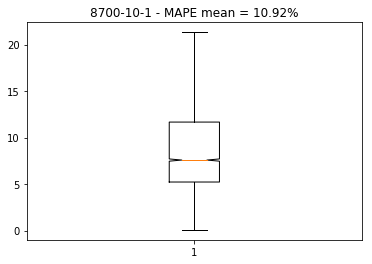

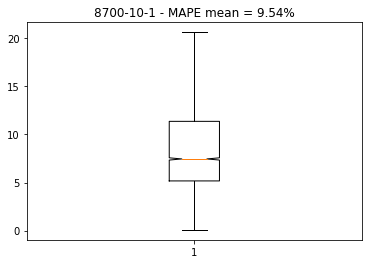

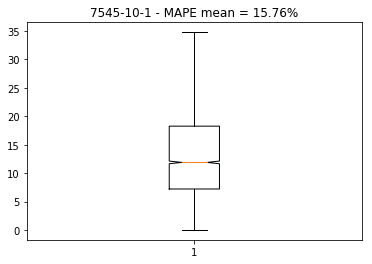

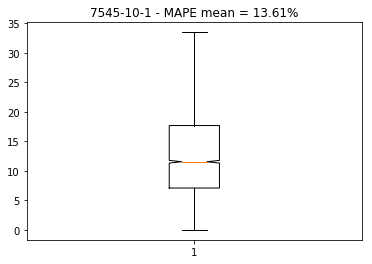

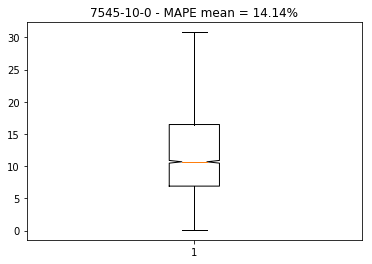

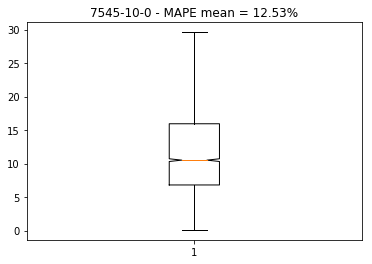

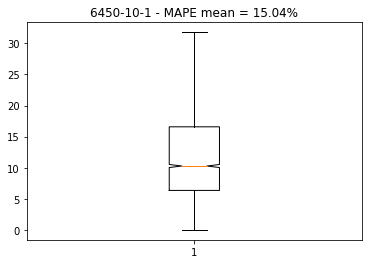

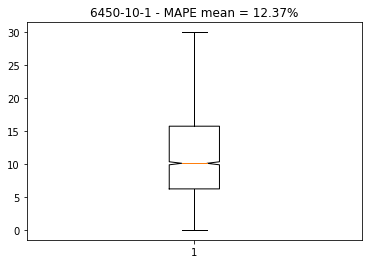

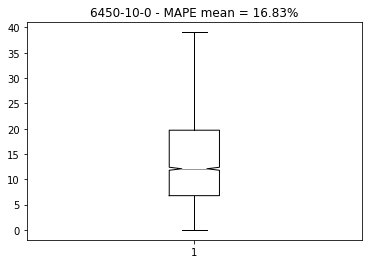

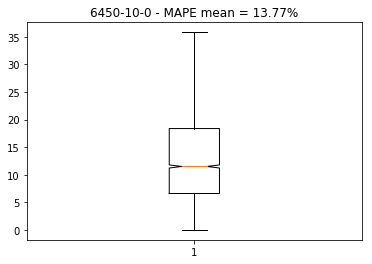

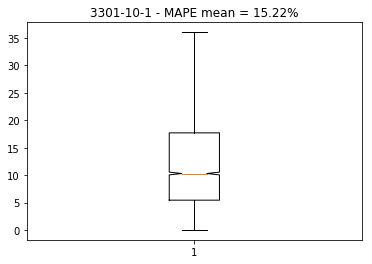

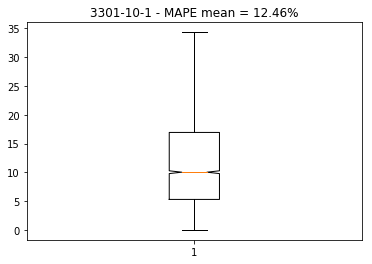

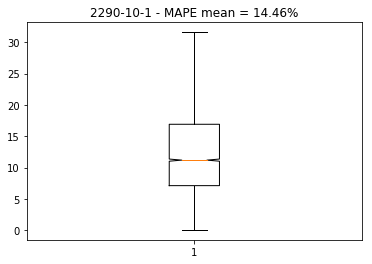

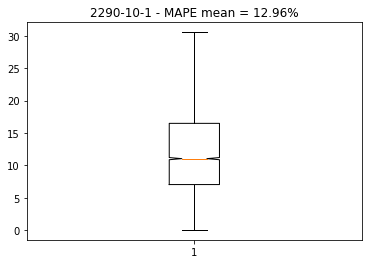

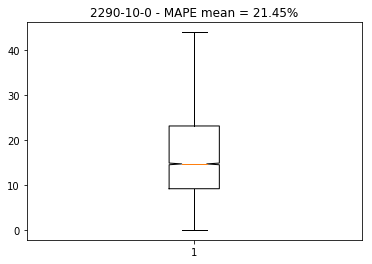

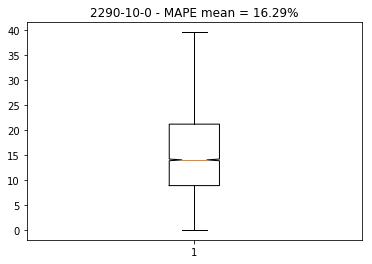

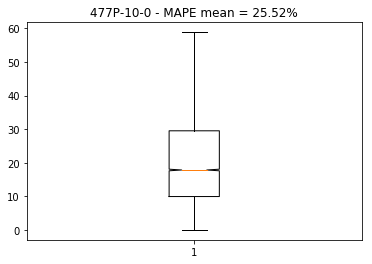

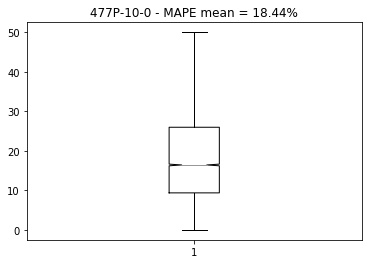

In [33]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import heapq 
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import dateutil
import datetime 
from time import time
import re
from scipy import interpolate
import timeit
from dateutil.rrule import DAILY, rrule, MO, TU, WE, TH, FR
import seaborn as sns

from sklearn.metrics import mean_absolute_error
import math

import sys
sys.path.append("../")


from historical.readData.old.estimateData3 import read

from historical.readData.old.estimateData3 import read
from historical.readData.old.estimateData3 import search_travels
from historical.readData.old.estimateData3 import estimate
from historical.readData.old.estimateData3 import stops_distance

from historical.readData.old.travels3 import haversine2

def calcula_dist_shape(selec_linhas):
    distance_all_shapes = {}
    # print 'Calculando distancias dos shapes'
    '''calcula todas as distancias dos shapes'''
    
    pth_files_GTFS = "../historical/readData/dados/gtfs/"        
        
    trips = pd.read_csv(pth_files_GTFS + 'trips.txt', sep=',')
    shapes = pd.read_csv(pth_files_GTFS + 'shapes.txt', sep=',')
    
    for l, trip_id in enumerate(selec_linhas):

        trip = trips[trips.trip_id == trip_id]
        trip_shape = shapes[shapes['shape_id'].isin(trip['shape_id'])]
        shapelat = trip_shape.shape_pt_lat.tolist()
        shapelon = trip_shape.shape_pt_lon.tolist()

        # distancias dos shapes
        lon1 = shapelon[0]
        lat1 = shapelat[0]
        totalcal = [0.]
        dist = [0.]
        for lat2, lon2 in zip(shapelat[1:], shapelon[1:]):
            d = haversine2(lat1, lon1, lat2, lon2)
            d = d * 1000
            dist.append(d)
            totalcal.append(totalcal[-1] + d)
            lat1 = lat2
            lon1 = lon2
        distance_all_shapes[trip_id] = [shapelat, shapelon, totalcal]
    return distance_all_shapes

def stops_distance(linha):

    distances = calcula_dist_shape([linha])
    totalcal = distances[linha][2]
    
    pth_files_GTFS = "../historical/readData/dados/gtfs/"
    

    trips = pd.read_csv(pth_files_GTFS + 'trips.txt', sep=',')
    shapes = pd.read_csv(pth_files_GTFS + 'shapes.txt', sep=',')
    stops = pd.read_csv(pth_files_GTFS + 'stops.txt', sep=',')
    stopid = pd.read_csv(pth_files_GTFS + 'stop_times.txt', sep=',')   

    ida = trips[trips.trip_id == linha]
    shapeida = shapes[shapes['shape_id'].isin(ida['shape_id'])]
    idalat = shapeida.shape_pt_lat.tolist()
    idalon = shapeida.shape_pt_lon.tolist()
    total = shapeida.shape_dist_traveled.tolist()

    temp1 = stopid[stopid.trip_id == linha]
    stopsida = stops[stops['stop_id'].isin(temp1['stop_id'])]
    stopsida = stopsida.set_index('stop_id')
    stopsida = stopsida.reindex(index=temp1['stop_id'])

    stopslat = stopsida.stop_lat.tolist()
    stopslon = stopsida.stop_lon.tolist()

    dpontos = [None] * len(stopslat)
    index = 0
    lat = idalat
    lon = idalon
    total = 0
    p = ['depois'] * len(stopslat)
    for latb, lonb, i in zip(stopslat, stopslon, range(len(stopslat))):
        lat = lat[index:]
        lon = lon[index:]
        nn = haversine2(latb, lonb, np.array(lat), np.array(lon)) * 1000
        index = nn.argmin()
        total = total + index
        if index == 0:
            dpontos[i] = nn[index]
#            descontardist = nn[index]
        else:
            if totalcal[total] >= totalcal[total - 1] + nn[index - 1]:
                p[i] = 'antes'
            dpontos[i] = totalcal[total - 1] + nn[index - 1]

    mid_points = []
#    mid_points.append(200)
    p1 = dpontos[0]
    for p2 in dpontos[1:]:
        mid_points.append(p1 + (p2-p1)/2)
        p1 = p2
    dpontos = [i/1000. for i in dpontos]
    mid_points = [i/1000. for i in mid_points]
    
    return dpontos, mid_points

def read(filedata,filerep):
    df0 = pd.read_pickle(filedata, compression=None)
    with open(filerep, 'rb') as handle:
        reps = pickle.load(handle, encoding='latin1')
    return df0, reps

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + datetime.timedelta(n)
        
def daterangeWD(start_date, end_date):
  return rrule(DAILY, dtstart=start_date, until=end_date, byweekday=(MO,TU,WE,TH,FR))

def hr_func(ts):
    return ts.hour

def minute_func(ts):
    return ts.minute

def second_func(ts):
    return ts.second

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')


# if __name__ == '__main__':

selected_line = ['8700-10-1']

selected_line = ['8700-10-1',                
                '7545-10-1',
                '7545-10-0',
                '6450-10-1',
                '6450-10-0',
                '3301-10-1',
#                 '3301-10-0',
                '2290-10-1',
                '2290-10-0',
#                 '574J-10-1',
#                 '574J-10-0',
#                 '477P-10-1',
                '477P-10-0',
#                 '351F-10-1',
#                 '351F-10-0'
                ]

pth_files_GTFS = "../historical/readData/dados/gtfs/"

trips = pd.read_csv(pth_files_GTFS + 'trips.txt', sep=',')
shapes = pd.read_csv(pth_files_GTFS + 'shapes.txt', sep=',')
stops = pd.read_csv(pth_files_GTFS + 'stops.txt', sep=',')
stopid = pd.read_csv(pth_files_GTFS + 'stop_times.txt', sep=',')   

periods = ['morning', 'm_peak', 'i_peak', 'a_peak', 'night']

for line in selected_line:
#     line = selected_line[0]
    p, mp = stops_distance(line)
    pth_files_lines = "../historical/readData/"

    ### Operação demorada
    df, reps = read(pth_files_lines + "trips_" + line + ".dsk", pth_files_lines + "interps_" + line + ".rep")

    df['day'] = pd.to_datetime(df['day'], format = '%Y-%m-%d')
    df['start'] = pd.to_datetime(df['start'], format = '%H:%M:%S')

    end_date = datetime.date(2017, 9, 1)        

    df = df.loc[((df['day'] >= end_date) & (df['holiday'] != 1)) & ((df['weekday'] != 6) & (df['weekday'] != 5) & (df['weekday'] != 4) & (df['weekday'] != 0))]

    df['exact_time'] = np.array(df['day'], dtype='datetime64[ns]') + \
                        pd.to_timedelta(pd.to_timedelta(pd.DatetimeIndex(df['start']).hour*60 + \
                        pd.DatetimeIndex(df['start']).minute + \
                        pd.DatetimeIndex(df['start']).second/60 + \
                        df['time'], unit='m'))

    df.index = df['exact_time']
    df.iloc[df.index.indexer_between_time('08:00', '20:00')]

    df['day_hour'] = df['exact_time'].apply(hr_func)

    df['link'] = 0
    for i in range(0, len(mp)):
        if (i == 0):
              df.loc[df.loc[(df['distance'] > 0) & (df['distance'] < mp[i+1]),]['link'].index,'link'] = i    
        if (i == len(mp) -1):
            df.loc[df.loc[(df['distance'] > mp[i]) & (df['distance'] < max(p)),]['link'].index,'link'] = i    
        if (i != 0) & (i != len(mp)-1):
            df.loc[df.loc[(df['distance'] >= mp[i]) & (df['distance'] < mp[i+1]),]['link'].index,'link'] = i    

    df = df.drop_duplicates(subset=['day', 'numtravel', 'link', 'day_hour'])   

    link_df = []
    travels = sorted(list(set(df.numtravel.unique())))
    for tr in travels:
        tck = reps[tr][0]
        tck_mods = [(tck[0],tck[1]-m,tck[2]) for m in mp]       
        tempo = [a[0] if a.size>0 else np.nan for a in [interpolate.sproot(tck_mod) for tck_mod in tck_mods]]
        row = [tuple([tempo[i+1]-pos for i, pos in enumerate(tempo[:-1])])]    
        link_df.append(row)

    travel_times = pd.DataFrame(np.reshape(link_df, (np.shape(link_df)[0], np.shape(link_df)[2])))
    travel_times.index = travels
    
    MAPE_array = []

    selected_day = df.day.dt.strftime('%Y-%m-%d').unique()
    for day_iteration in range(0, len(selected_day) -1):
        for link in range(1, len(mp)-2):
            df_temp = df.loc[(df['day'] == selected_day[day_iteration]) & (df['link'] == link)]
            df_test = df.loc[(df['day'] == selected_day[day_iteration+1]) & (df['link'] == link)]

            for hour_day in range(640, 1320, 30):   
                int_part, float_part = divmod((hour_day/60), 1)

                if float_part != 0:
                    hour_begin = str(int(int_part)) + ':' + '30'
                    hour_end = str(int(int_part + 1 )) + ':' + '00'                
                else:
                    hour_begin = str(int(int_part)) + ':' + '00'
                    hour_end = str(int(int_part)) + ':' + '30'


                df_temp_time = df_temp.iloc[df_temp.index.indexer_between_time( hour_begin, hour_end)]
                df_temp_test = df_test.iloc[df_test.index.indexer_between_time(hour_begin, hour_end)]

                median_test = np.mean(travel_times.loc[np.unique(np.array(df_temp_time['numtravel']))][link])
                time_tests = travel_times.loc[np.unique(np.array(df_temp_test['numtravel']))][link]
                
                if (len(time_tests) > 0) & (math.isnan(median_test) == False) & (np.isnan(time_tests).any() == False):
                    MAPE_array.append(mean_absolute_percentage_error([median_test]*len(time_tests), time_tests))


    
    MAPE_array = np.array(MAPE_array)
    print(line + ' MAPE(all) = ' + str(format(np.mean(MAPE_array), '.2f')) + '%')

    median_fig, ax = plt.subplots()
    ax.set_title(line + ' - MAPE mean = ' + str(format(np.mean(MAPE_array), '.2f')) + '%')
    ax.boxplot(MAPE_array, notch=True, showfliers=False)
    median_fig.savefig(line + '_mean_last_day_all.png' )


    MAPE_array = MAPE_array[MAPE_array < 50]    
    print(line + ' MAPE(Thresh > 50) = ' + str(format(np.mean(MAPE_array), '.2f')) + '%')

    median_fig, ax = plt.subplots()
    ax.set_title(line + ' - MAPE mean = ' + str(format(np.mean(MAPE_array), '.2f')) + '%')
    ax.boxplot(MAPE_array, notch=True, showfliers=False)
    median_fig.savefig(line + '_mean_last_day_MAPE-threshold.png' )
